In [3]:
import numpy as np 
import torch
import torch.nn as nn
import torch.nn.functional as F
from google.colab import files
import bcolz
import pickle
from torch.utils.data import TensorDataset, DataLoader

import csv
import json
import pandas as pd
from collections import Counter
import spacy
import re
nlp = spacy.load('en_core_web_sm')
#stopwords = nlp.Defaults.stop_words

In [2]:
!pip install bcolz

     |████████████████████████████████| 1.5 MB 6.1 MB/s 
  Created wheel for bcolz: filename=bcolz-1.2.1-cp37-cp37m-linux_x86_64.whl size=2643475 sha256=b3bb0184aea3d51ba1e1f2cb3b8b13338daa8ed243db21d204ec205971764a88
  Stored in directory: /root/.cache/pip/wheels/2c/35/ca/9d914de345914e2446ea285170329f771b8abba2a00f7650bd
Successfully built bcolz


# Glove Embeddings

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
words = []
idx = 0
word2idx = {}
glove_path = '/content/drive/MyDrive/505/project/CS505-final-project-main'
vectors = bcolz.carray(np.zeros(1), rootdir=f'{glove_path}/6B.100.dat', mode='w')

with open(f'{glove_path}/glove.6B.100d.txt', 'rb') as f:
    for l in f:
        line = l.decode().split()
        word = line[0]
        words.append(word)
        word2idx[word] = idx
        idx += 1
        vect = np.array(line[1:]).astype(np.float)
        vectors.append(vect)
    
vectors = bcolz.carray(vectors[1:].reshape((400000, 100)), rootdir=f'{glove_path}/6B.100.dat', mode='w')
vectors.flush()
pickle.dump(words, open(f'{glove_path}/6B.100_words.pkl', 'wb'))
pickle.dump(word2idx, open(f'{glove_path}/6B.100_idx.pkl', 'wb'))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [6]:
glove_path = '/content/drive/MyDrive/505/project/CS505-final-project-main'
vectors = bcolz.open(f'{glove_path}/6B.100.dat')[:]
words = pickle.load(open(f'{glove_path}/6B.100_words.pkl', 'rb'))
words += ['<UNK>', '<s>', '</s>', 'PAD']
vocab_list_glove = set(words)
new_vecs = np.random.normal(loc=0.0, scale=.6, size=(4,100) )
vectors = np.vstack((vectors, new_vecs))
word2idx = pickle.load(open(f'{glove_path}/6B.100_idx.pkl', 'rb'))
word2idx['<UNK>'] = 400000
word2idx['<s>'] = 400001
word2idx['</s>'] = 400002
word2idx['PAD'] = 400003

## Tweets pre-processing

In [31]:
path = '/content/drive/MyDrive/505/project/'


def read_json(filename: str):
    with open(filename, "r") as file:
        data = json.load(file)

    return data

# Extract tweets and retweet numbers
train = read_json(f'{path}/train.json')
content = [item['text'] for item in train]
retweet_num = [item['retweet_count'] for item in train]
print(len(content))
print(len(retweet_num))

96562
96562


In [39]:
# Clean tweets
def pre_process(data):
  clean_data = []
  counts = 0
  for line in data:
    line = re.sub(r"https?:\/\/\S+\b|www\.(\w+\.)+\S*", "url", line) 
    line = re.sub("[^a-z@' ]", "", line.lower()) 
    doc = nlp(line)
    temp = []
    for token in doc: 
      if token.text == 'url':
        temp.append('<url>')
      else:
        temp.append(token.text)
    
    temp_2 = " ".join(temp)  
    text = re.sub(r"@\w+", "<user>", temp_2)
    clean_data.append(text)
    counts += 1
  print(counts)
    

  return clean_data

tweets = pre_process(content)

96562


In [44]:
# Save pre-process tweets
file = open(f'{path}/train_clean_text.txt', "w")
for item in tweets:
    file.write(item + "\n")
file.close()

In [58]:
# Loading processed tweets
#tweets = pd.read_csv(f'{path}/train_clean_text.txt', header = None)
tweets = []
with open(f'{path}/train_clean_text.txt', 'r') as f:
    for line in f:
      tweets.append(line[:-1])
print(len(tweets))

96562


In [179]:
# Import Meta Data
meta_data = pd.read_csv(f'{glove_path}/final_data.csv')
meta = meta_data.iloc[:,1:]
print(meta.shape)

(96562, 8)


In [180]:
meta.head(2)

,user_friends_count,user_followers_count,user_created_at,favorite_count,user_statuses_count,photo,animated_gif,video
0,13723,120597,1247653266000000000,0,153810,0,0,0
1,13723,120597,1247653266000000000,0,153810,0,0,0


In [181]:
meta['tweet'] = tweets
print(meta.shape)


(96562, 9)


In [184]:
# Train test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(meta, retweet_num, test_size=0.2, random_state=42)
print(len(X_train), len(X_test))

77249 19313


In [187]:
X_train_tweet = X_train.tweet
X_test_tweet = X_test.tweet

X_train_meta = X_train.iloc[:,:-1]
X_test_meta = X_test.iloc[:,:-1]

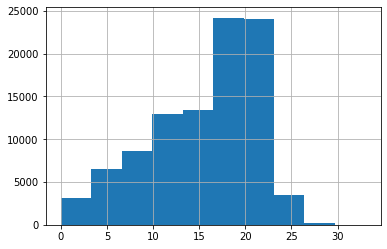

count    96562.000000
mean        15.556782
std          5.810485
min          0.000000
25%         11.000000
50%         17.000000
75%         20.000000
max         33.000000
dtype: float64

In [64]:
# Visalize the length of tweets
# tweets length of 20 will be chosen
import matplotlib.pyplot as plt
%matplotlib inline
tweets_len = [len(x.split()) for x in tweets]
pd.Series(tweets_len).hist()
plt.show()
pd.Series(tweets_len).describe()

In [188]:
# Building vocabulary for training data
def word_count(data):
  words_counter = Counter()
  for line in data:
    words =  line.split()
    for w in words:
      words_counter.update([w])
  
  words_counter_clean = {k:v for k,v in words_counter.items() if v > 1} # Removing the words that only appear once
  sorted_words = sorted(words_counter_clean, key = words_counter_clean.get, reverse = True) # Sorting the words frequency in desc order
  sorted_words = ['UNK','PAD', '<s>', '</s>' ] + sorted_words 

  return words_counter, words_counter_clean, sorted_words
  
words_counter, words_counter_clean, sorted_words = word_count(X_train_tweet)

In [148]:
# Not using slicing window padding
def padding(data, seq_len):
  sequences = []
  for line in data:
    line = f"{'<s>'} {line} {'</s>'}"
    n_token = len(line.split())
    
    if n_token >= seq_len:
      seq = line.split()[:seq_len] 
      sequences.append(" ".join(seq))

    else:
      seq = line.split()
      for i in range(seq_len - n_token):
          seq.append('PAD')
      sequences.append(" ".join(seq))
  return sequences

X_train_pad = padding(X_train_tweet, 20)
X_test_pad = padding(X_test_tweet, 20)

In [152]:
# replace the words that only appear once with UNKNOWN
def generate_sentence(data):
  sequences = []
  for line in data:
    temp = []
    words = line.split()
    for word in words:
      if word in sorted_words:
        temp.append(word)
      else:
        temp.append('UNK')
    sequences.append(" ".join(temp))
  return sequences

X_train_final = generate_sentence(X_train_pad)
X_test_final = generate_sentence(X_test_pad)

In [ ]:
# Using glove weights
glove = {w: vectors[word2idx[w]] for w in words}
matrix_len = len(sorted_words)
weights_matrix = np.zeros((matrix_len, 100))
words_found = 0

for i, word in enumerate(sorted_words):
  try: 
    weights_matrix[i] = glove[word] # if alr in the vocab, load its pre-trained word vector.
    words_found += 1
  except KeyError:
    weights_matrix[i] = np.random.normal(scale=0.6, size=(100, ))

In [156]:
# Using tweets training data vocabulary

# Dictionaries to store the word to index mappings and vice versa
word2idx = {o:i for i,o in enumerate(sorted_words)}
idx2word = {i:o for i,o in enumerate(sorted_words)}


# convert text sequences to integer sequences
X_train_int = np.zeros((len(X_train_final), 20), dtype = int)
for i, data in enumerate(X_train_final):
  X_train_int[i] = [word2idx[w] for w in data.split()]

X_test_int = np.zeros((len(X_test_final), 20), dtype = int)
for i, data in enumerate(X_test_final):
  X_test_int[i] = [word2idx[w] for w in data.split()]



In [157]:
# convert lists to numpy arrays
X_train_int = np.array(X_train_int)
y_train_int = np.array(y_train)

X_test_int = np.array(X_test_int)
y_test_int = np.array(y_test)

In [158]:
from torch.utils.data import DataLoader, TensorDataset


# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(X_train_int), torch.from_numpy(y_train_int))
test_data = TensorDataset(torch.from_numpy(X_test_int), torch.from_numpy(y_test_int))

# dataloaders
batch_size = 50

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

# Neural Net

### Retweet Network: Takes in a tweet as input, can use embedded version, and can any combination of bidirectional, LSTM, GRU, concatenates it with metadata vector, and uses a feedforward neural net with 1 hidden layer to perform a regression prediction on the retweet count. 

#### Parameter custom_embeddings is either a tuple: (weight_matrix , none_trainable), or None.
#### none_trainable is either True or False or Nothing

In [ ]:
def create_emb_layer(weights_matrix, non_trainable=False):
  num_embeddings, embedding_dim = weights_matrix.shape
  emb_layer = nn.Embedding(num_embeddings, embedding_dim)
  emb_layer.load_state_dict({'weight': torch.from_numpy(weights_matrix)})
  if non_trainable:
      emb_layer.weight.requires_grad = False
  return emb_layer, num_embeddings, embedding_dim

class RetweetNet(nn.Module):
  def __init__(self, vocab_size, hidden_state_sizes, meta_data_len, output_size, embedding_dim, hidden_dim, 
                 n_layers, drop_prob=0.5, custom_embeddings = None, bidirectional = False, GRU = False):
    super().__init__()
    self.GRU_val = GRU
    self.bidirectional = bidirectional
    self.output_size = output_size
    self.n_layers = n_layers
    self.hidden_dim = hidden_dim
        
    if custom_embeddings is None: 
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
    else: 
        assert len(custom_embeddings) == 2 and isinstance(custom_embeddings, tuple), "custom embeddings must be of form: (weight_matrix, non_trainable)"
        weights_matrix, non_trainable = custom_embeddings
        self.embedding, num_embeddings, embedding_dim = create_emb_layer(weights_matrix, non_trainable)
        
    if GRU == False: 
        self.Gate = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=drop_prob, batch_first=True, bidirectional = bidirectional)
    else: 
        self.Gate = nn.GRU(embedding_dim, hidden_dim, n_layers, 
                              dropout=drop_prob, batch_first=True, bidirectional = bidirectional)
    self.dropout = nn.Dropout(0.2)
    self.fc1 = nn.Linear(hidden_dim, hidden_state_sizes[0])
    self.relu = nn.RELU()
        
    #hidden_state_sizes[0] is the size of the output of lstm 
    self.fc2 = nn.Linear(hidden_state_sizes[0] + meta_data_len, hidden_state_sizes[1])
        
    #hidden_state_sizes[1] is the size of the first and only hidden layer
    self.fc3 = nn.Linear(hidden_state_sizes[1], 1)

        
  def forward(self, x, meta_data, hidden):
    batch_size = x.size(0)
    x = x.long()
    embeds = self.embedding(x)
    gru_out, hidden = self.Gate(embeds, hidden)
    gru_out = gru_out.contiguous().view(-1, self.hidden_dim)
    
    out = self.dropout(gru_out)
    out = self.fc1(out)
    out = out.view(batch_size, -1)
    out = out[:,-1] 
    meta_data = meta_data.view(batch_size, -1)
        
    # combine hidden state and meta_data
    out = torch.cat((out, meta_data), dim = 1) #meta_data is of shape (batch_size, -1)
        
    out = self.fc2(out)
        
    # applying dropout before relu since relu already sets some neurons to 0
    out = self.dropout(out)
    out = self.relu(out)
    out = self.fc3(out)
        
    return out, hidden
    
  def init_hidden(self, batch_size):
    weight = next(self.parameters()).data
    n = 1
    if self.bidirectional == True: 
      n = 2
    if self.GRU_val == False:
      return (weight.new(self.n_layers * n, batch_size, self.hidden_dim).zero_().to('cuda'),
              weight.new(self.n_layers * n, batch_size, self.hidden_dim).zero_().to('cuda'))
    else:
      return  weight.new(self.n_layers * n, batch_size, self.hidden_dim).zero_().to('cuda')


def train_retweet_predictor(model, epochs = 2,print_every = 1000, clip = 5, valid_loss_min = np.Inf, lr=0.005, batch_size = 400, device = 'cuda', GRU = False, weight_decay = 1e-5): 
  counter = 0
  model.train()
    
  criterion = nn.MSELoss()
    
  # weight decay is the l2 regularization penalty 
  optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    
  for i in range(epochs):
    h = model.init_hidden(batch_size)

  for inputs, labels in train_loader:
    counter += 1
    if GRU == False: 
      h = tuple([each.data for each in h])
    else:
      h = h.data
    inputs, labels = inputs.to(device), labels.to(device)
    model.zero_grad()
    output, h = model(inputs, h)
    loss = criterion(output.squeeze(), labels.float())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), clip)
    optimizer.step()
    print("Epoch: {}/{}...".format(i+1, epochs),
          "Step: {}...".format(counter),
          "Loss: {:.6f}...".format(loss.item()))
          
def error_retweet_predictor(model, batch_size = 359, device = 'cuda', GRU = False): 
  test_losses = []
  num_correct = []
  model.cuda()

  h = model.init_hidden(batch_size)
  criterion = nn.MSELoss()

  model.eval()
  for inputs, labels in test_loader:
    if GRU == True: 
      h = h.data
    else: 
      h = tuple([each.data for each in h])
    inputs, labels = inputs.to(device), labels.to(device)
    output, h = model(inputs, h)
    test_loss = criterion(output.squeeze(), labels.float())
    test_losses.append(test_loss.item())
    pred = torch.round(output.squeeze())
        
    errors = torch.sum(torch.square(pred - labels.float().view_as(pred)), axis= 1)/(predicted_x.size()[0]
    num_correct.append(np.squeeze(errors.cpu().numpy()))    
  print("Test loss: {:.3f}".format(np.mean(test_losses)))
  print("Test accuracy: {:.3f}%".format(np.mean(num_correct)))